In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
from torchvision.transforms import Compose, Resize, ToTensor
from torch.utils.data import DataLoader, random_split

from dataset import DogDataset
from model import UNet
from evaluate_model import evaluate_model

# Hyper parameters

In [2]:
BATCH_SIZE = 8
EPOCHS = 20
LEARNING_RATE = 1e-4
NUM_OF_CLASSES = 1
TAKE_INDEXES_BELOW = 41

# Loading data set

In [3]:
dog_dataset_dir = "DatasetOxford"
transform_for_unet = Compose([
    Resize((512,512)),
    ToTensor(),
])

dog_dataset = DogDataset(dataset_dir=dog_dataset_dir, indexes_below=TAKE_INDEXES_BELOW, transform=transform_for_unet)
print("Length of dataset: ", len(dog_dataset))




Length of dataset:  992


# Dividing data into train, validation and test sets

In [4]:
train_data_length = math.ceil(0.7 * len(dog_dataset))
validation_data_length = math.ceil(0.15 * len(dog_dataset))
test_data_length = len(dog_dataset) - train_data_length - validation_data_length

train_data, valid_data, test_data = random_split(dog_dataset, [train_data_length, validation_data_length, test_data_length])

print("Test dataset length: ", len(test_data))
print("Validation dataset length: ", len(valid_data))
print("Train dataset length: ", len(train_data))
print("Sum = ", (len(test_data) + len(valid_data) + len(train_data)))

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

Test dataset length:  148
Validation dataset length:  149
Train dataset length:  695
Sum =  992


# Visualising data

Data batch shape: torch.Size([8, 3, 512, 512])
Labels batch shape: torch.Size([8, 1, 512, 512])
torch.Size([512, 512])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


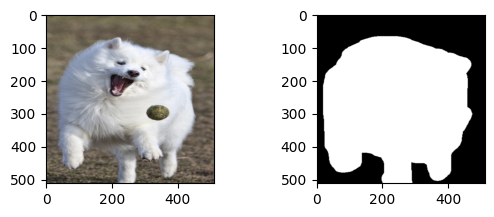

In [5]:
data_imges, label_imges = next(iter(train_dataloader))
print(f"Data batch shape: {data_imges.size()}")
print(f"Labels batch shape: {label_imges.size()}")

data_img = data_imges[0].permute(1, 2, 0).numpy()
label_img = label_imges[0].squeeze()

print(label_img.shape)
print(label_img)

figure = plt.figure()
ax1 = figure.add_subplot(2,2,1)
ax1.imshow(data_img)
ax2 = figure.add_subplot(2,2,2)
ax2.imshow(label_img, cmap="gray")
plt.show()

In [6]:
# torch.set_printoptions(threshold=10000000)
# print(label_img)
# torch.set_printoptions(threshold=1000)
print(torch.max(label_img))

tensor(1.)


# Model creation

### Checking if the model looks correct

In [7]:
input_image = torch.rand((1, 3, 512, 512))
model_test = UNet(num_classes=NUM_OF_CLASSES)
# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in model_test.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model_test.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")
outputs = model_test(input_image)
print(outputs.shape)

31,031,745 total parameters.
31,031,745 training parameters.
torch.Size([1, 1, 512, 512])


### Initializing a model

In [8]:
model = UNet(num_classes=NUM_OF_CLASSES)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

### Training (without validation)

In [ ]:
for epoch in range(EPOCHS):
    model.train()
    train_running_loss = 0
    print(f"Current EPOCH {epoch + 1}")

    for idx, data in (enumerate(train_dataloader)):
        img = data[0].float().to(device)
        mask = data[1].float().to(device)

        predicted_mask = model(img)
        optimizer.zero_grad()

        loss = loss_fn(predicted_mask, mask)
        single_loop_loss = loss.item()
        train_running_loss += single_loop_loss
        

        loss.backward()
        optimizer.step()
        print(f"    Batch {idx + 1} running loss: {single_loop_loss}")

    train_loss = train_running_loss / (idx + 1)

    print(f"Train Loss EPOCH {epoch + 1}: {train_loss:.4f}")

Current EPOCH 1


KeyboardInterrupt: 

# Inference of a model

tensor([[[[0.2894, 0.1894, 0.1420,  ..., 0.1691, 0.2259, 0.3283],
          [0.2120, 0.1052, 0.0689,  ..., 0.0806, 0.1282, 0.2401],
          [0.1777, 0.0787, 0.0481,  ..., 0.0510, 0.0903, 0.2012],
          ...,
          [0.1410, 0.0474, 0.0235,  ..., 0.0130, 0.0308, 0.1162],
          [0.1934, 0.0833, 0.0503,  ..., 0.0310, 0.0632, 0.1663],
          [0.3137, 0.2062, 0.1591,  ..., 0.1288, 0.1741, 0.2900]]]],
       device='cuda:0')
MAX: 
1


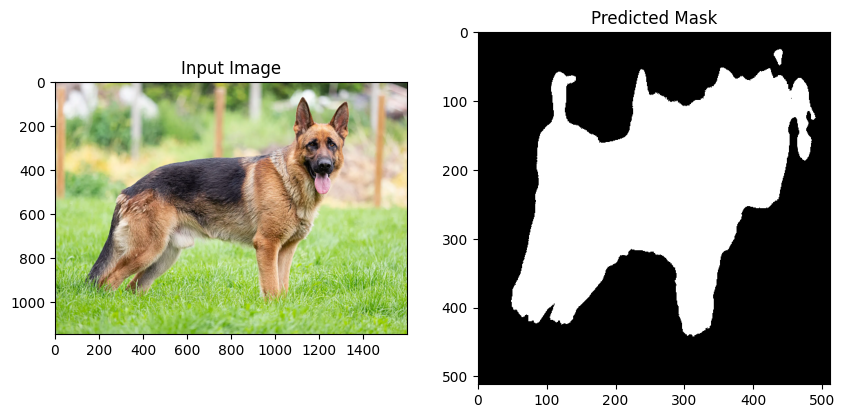

In [ ]:
# Set the model in evaluation mode for inference
model.eval()

# Define a transform for the test image
inference_transform = Compose([Resize((512, 512)), ToTensor()])

# Load and preprocess the test image
# test_image_path = "scottish_terrier_101.jpg"
# test_image_path = "inference_img.jpg"
test_image_path = "inference_img2.webp"
test_image = Image.open(test_image_path).convert("RGB")
input_tensor = inference_transform(test_image).unsqueeze(0).to(device)  # Add batch dimension and move to device

# Run inference
with torch.no_grad():  # No gradient computation needed
    predicted_output = model(input_tensor)
    predicted_output = torch.sigmoid(predicted_output)

print(predicted_output)
# Apply sigmoid and threshold to create a binary mask
binary_mask = predicted_output.squeeze().cpu().numpy()  # Apply sigmoid to get probabilities
binary_mask = (binary_mask > 0.4).astype(int)  # Threshold at 0.5 to create a binary mask
print("MAX: ")
print(np.max(binary_mask))

# Visualize the result
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(test_image)
plt.title("Input Image")
plt.subplot(1, 2, 2)
plt.imshow(binary_mask, cmap="gray")
plt.title("Predicted Mask")
plt.show()


In [ ]:
mean_iou, mean_accuracy = evaluate_model(model, test_dataloader, device)

In evaluate
Mean IoU: 0.4400
Mean Accuracy: 0.7462


# Model with validation and adaptive learning rate

### Model initialization

In [ ]:
model_w_valid = UNet(num_classes=NUM_OF_CLASSES)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_w_valid.to(device)

loss_fn_valid = nn.BCEWithLogitsLoss()
optimizer_valid = torch.optim.Adam(model_w_valid.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_valid, mode='min', factor=0.5, patience=3, verbose=True)

# Variable to track the best validation loss
best_val_loss = float('inf')
best_model_path = "best_model.pth"  # File path to save the best model

c:\Users\MatG\Desktop\DataAnalysis\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


### Training with validation

In [ ]:
for epoch in range(EPOCHS):
    model_w_valid.train()
    train_running_loss = 0
    print(f"Current EPOCH {epoch + 1}")

    # Training Loop
    for idx, data in enumerate(train_dataloader):
        img = data[0].float().to(device)
        mask = data[1].float().to(device)

        # Forward pass
        predicted_mask = model_w_valid(img)
        optimizer_valid.zero_grad()

        # Compute loss
        loss = loss_fn_valid(predicted_mask, mask)
        train_running_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer_valid.step()

    # Average training loss
    train_loss = train_running_loss / (idx + 1)
    print(f"Train Loss EPOCH {epoch + 1}: {train_loss:.4f}")

    # Validation Loop
    model_w_valid.eval()
    val_running_loss = 0
    with torch.no_grad():
        for val_idx, val_data in enumerate(valid_dataloader):
            val_img = val_data[0].float().to(device)
            val_mask = val_data[1].float().to(device)

            # Forward pass for validation
            val_predicted_mask = model_w_valid(val_img)
            val_loss = loss_fn_valid(val_predicted_mask, val_mask)
            val_running_loss += val_loss.item()

    # Average validation loss
    val_loss = val_running_loss / (val_idx + 1)
    print(f"Validation Loss EPOCH {epoch + 1}: {val_loss:.4f}")

    # Checkpoint model if the validation loss is the best we've seen so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model_w_valid.state_dict(), best_model_path)
        print(f"New best model saved with validation loss: {val_loss:.4f}")

    # Step the scheduler with the latest validation loss
    scheduler.step(val_loss)

    # Switch model back to training mode for the next epoch
    model_w_valid.train()

Current EPOCH 1
Train Loss EPOCH 1: 0.6851
Validation Loss EPOCH 1: 0.6767
New best model saved with validation loss: 0.6767
Current EPOCH 2
Train Loss EPOCH 2: 0.6769
Validation Loss EPOCH 2: 0.6700
New best model saved with validation loss: 0.6700
Current EPOCH 3
Train Loss EPOCH 3: 0.6575
Validation Loss EPOCH 3: 0.6297
New best model saved with validation loss: 0.6297
Current EPOCH 4
Train Loss EPOCH 4: 0.6362
Validation Loss EPOCH 4: 0.6123
New best model saved with validation loss: 0.6123
Current EPOCH 5
Train Loss EPOCH 5: 0.6198
Validation Loss EPOCH 5: 0.6434
Current EPOCH 6
Train Loss EPOCH 6: 0.5694
Validation Loss EPOCH 6: 0.5123
New best model saved with validation loss: 0.5123
Current EPOCH 7
Train Loss EPOCH 7: 0.5314
Validation Loss EPOCH 7: 0.4970
New best model saved with validation loss: 0.4970
Current EPOCH 8
Train Loss EPOCH 8: 0.5176
Validation Loss EPOCH 8: 0.4866
New best model saved with validation loss: 0.4866
Current EPOCH 9
Train Loss EPOCH 9: 0.5036
Validat

### Inference of model with validation

C:\Users\MatG\AppData\Local\Temp\ipykernel_37960\171321188.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_w_valid.load_state_dict(torch.load(best_model_path, map_

tensor([[[[0.3223, 0.2535, 0.2271,  ..., 0.1919, 0.2298, 0.3009],
          [0.2435, 0.1721, 0.1568,  ..., 0.1131, 0.1407, 0.2252],
          [0.2146, 0.1531, 0.1404,  ..., 0.0837, 0.1137, 0.1856],
          ...,
          [0.1874, 0.0906, 0.0608,  ..., 0.0171, 0.0340, 0.1071],
          [0.2238, 0.1253, 0.0909,  ..., 0.0326, 0.0584, 0.1426],
          [0.3183, 0.2334, 0.1949,  ..., 0.1162, 0.1588, 0.2648]]]],
       device='cuda:0')
MAX: 
1


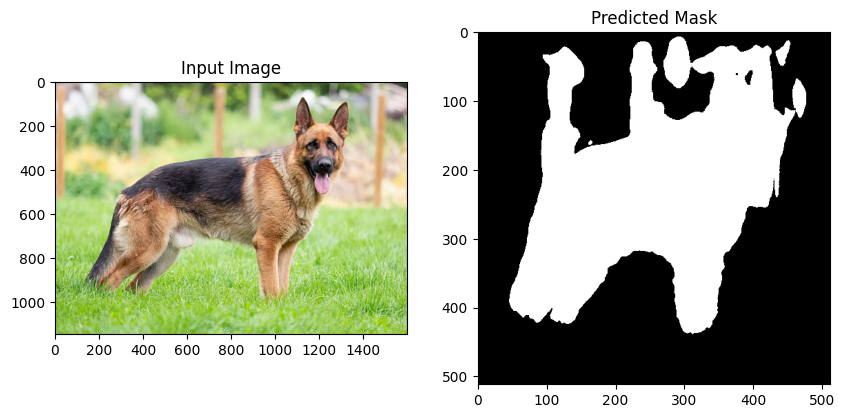

In [ ]:
# Set the model in evaluation mode for inference
model_w_valid.load_state_dict(torch.load(best_model_path, map_location=device))
model_w_valid.eval()

# Define a transform for the test image
inference_transform = Compose([Resize((512, 512)), ToTensor()])

# Load and preprocess the test image
# test_image_path = "scottish_terrier_101.jpg"
# test_image_path = "inference_img.jpg"
test_image_path = "inference_img2.webp"
test_image = Image.open(test_image_path).convert("RGB")
input_tensor = inference_transform(test_image).unsqueeze(0).to(device)  # Add batch dimension and move to device

# Run inference
with torch.no_grad():  # No gradient computation needed
    predicted_output = model_w_valid(input_tensor)
    predicted_output = torch.sigmoid(predicted_output)

print(predicted_output)
# Apply sigmoid and threshold to create a binary mask
binary_mask = predicted_output.squeeze().cpu().numpy()  # Apply sigmoid to get probabilities
binary_mask = (binary_mask > 0.4).astype(int)  # Threshold at 0.5 to create a binary mask
print("MAX: ")
print(np.max(binary_mask))

# Visualize the result
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(test_image)
plt.title("Input Image")
plt.subplot(1, 2, 2)
plt.imshow(binary_mask, cmap="gray")
plt.title("Predicted Mask")
plt.show()

### Evaluation of a model with validation

In [ ]:
mean_iou, mean_accuracy = evaluate_model(model_w_valid, test_dataloader, device)

In evaluate
Mean IoU: 0.5873
Mean Accuracy: 0.7924
